## use the data of PET and and rainfall to predict the Q

#preprocessing


In [0]:
#!/usr/bin/env python
# coding: utf-8


from tensorflow.keras import Sequential, optimizers, metrics
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler



df = pd.read_csv('/content/SILO3.csv')
df = df.interpolate()
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
# print(df.head(), df.shape)
df.set_index('Date', drop=True, inplace=True)

df.shape


(18929, 17)

In [0]:

TIME_STEPS = 30


def preprocess(data, ratio=0.8):
    num_samples = data.shape[0] - TIME_STEPS + 1  # 18129  - TIME_STEPS + 1
    train_size = int(num_samples * ratio)  # 80%
    columns = int(data.shape[1])  # 17
    x_train, x_test = [], []
    y_train, y_test = [], []

    all_data = np.array(data.iloc[:, :])

    # normalize the data
    std_x = StandardScaler()
    std_x.fit(all_data[:train_size + TIME_STEPS - 1, :-1])
    all_data[:, :-1] = std_x.transform(all_data[:, :-1])

    for i in range(num_samples):
        sample = np.array(all_data[i:i+TIME_STEPS, :])  # [TIME_STEPS, 17] tensor
        y = sample[-1, -1]
        sample[-1, -1] = -1.0  # to prevent data leaking

        if i < train_size:
            x_train.append(sample)
            y_train.append(y)
        else:
            x_test.append(sample)
            y_test.append(y)

    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    y_test = np.array(y_test)
    return x_train, y_train, x_test, y_test, num_samples, train_size, columns


x_train, y_train, x_test, y_test, dims, index, columns = preprocess(df)


def info(arr):
    print(arr.mean(), arr.std(), np.median(arr), arr.max(), arr.min())


print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

# x_train = x_train.reshape(index, columns - 1, 1)
# y_train = y_train.reshape(-1, )
# x_test = x_test.reshape(dims - index, columns - 1, 1)
# y_test = y_test.reshape(-1, )
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

#print(x_train)

##build the model

Train on 15120 samples, validate on 3780 samples
Epoch 1/50
15120/15120 [==============================] - 13s 884us/sample - loss: 0.5544 - R2: -3.0092 - val_loss: 0.5659 - val_R2: -0.7353
Epoch 2/50
15120/15120 [==============================] - 9s 563us/sample - loss: 0.1444 - R2: -0.0130 - val_loss: 0.8094 - val_R2: -1.4880
Epoch 3/50
15120/15120 [==============================] - 9s 566us/sample - loss: 0.1133 - R2: 0.1954 - val_loss: 0.8292 - val_R2: -1.5388
Epoch 4/50
15120/15120 [==============================] - 8s 534us/sample - loss: 0.1036 - R2: 0.2633 - val_loss: 0.6700 - val_R2: -1.0542
Epoch 5/50
15120/15120 [==============================] - 8s 549us/sample - loss: 0.0930 - R2: 0.3399 - val_loss: 0.7008 - val_R2: -1.1485
Epoch 6/50
15120/15120 [==============================] - 8s 538us/sample - loss: 0.0831 - R2: 0.4125 - val_loss: 0.6337 - val_R2: -0.9405
Epoch 7/50
15120/15120 [==============================] - 8s 561us/sample - loss: 0.0729 - R2: 0.4874 - val_loss: 

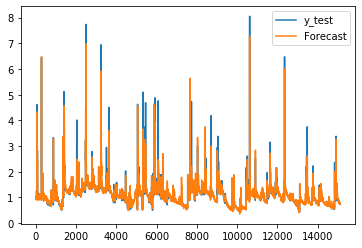

In [0]:

UNITS = 64
DROPOUT = 0.0
LR = 0.01
EPOCHES = 50
BATCH_SIZE = 2000


model = Sequential()

model.add(tf.keras.layers.LSTM(
    units=UNITS,
    dropout=DROPOUT,
    recurrent_dropout=DROPOUT,
    input_shape=(x_train.shape[1], x_train.shape[2]),
    return_sequences=True
))


model.add(tf.keras.layers.LSTM(
    units=UNITS,
    dropout=DROPOUT,
    recurrent_dropout=DROPOUT,
    return_sequences=False
))

# 1 outcome
model.add(tf.keras.layers.Dense(1))

# R^2
from keras import backend as K


def R2(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res / (SS_tot + K.epsilon()))


model.compile(
    optimizer=optimizers.Adam(lr=LR),
    loss='mse',
    metrics=[R2]
)


#tensorboard_callback = tf.keras.callbacks.TensorBoard('./Graph', histogram_freq= 1)

History = model.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHES,
    validation_data=(x_test, y_test),
    shuffle=True,
    #callbacks = [tensorboard_callback]
)

#prediction = model.predict(x_test)

#plt.plot(y_test[:], label='y_test')
#plt.plot(prediction[:], label='Forecast')
prediction = model.predict(x_train)

plt.plot(y_train[:], label='y_test')
plt.plot(prediction[:], label='Forecast')


plt.legend()
plt.show()



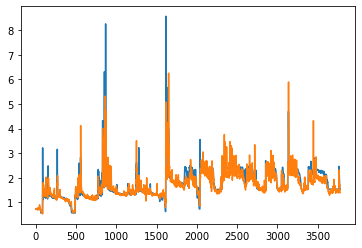

In [0]:
prediction = model.predict(x_test)

plt.plot(y_test, label='y_test')
plt.plot(prediction, label='Forecast')